# CWFS vignette analysis

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2022-07-05 <br>
Software Versions:
  - `ts_wep`: **v2.5.1**
  - `ts_phosim`: **v2.0.3**

## Notebook Objective:

In this notebook we will analyze the effects of vignetting on WEP Zernike Estimation and the convergence of the AOS closed loop. At the end we will establish a limit on the distance from the center of the LSSTCam focal plane for sources we will use in the WEP pipeline.

## Logistics

This notebook is intended to be run on the RSP https://lsst-rsp-stable.ncsa.illinois.edu/nb. The data set is on NCSA.

In [1]:
import os
from lsst.daf.butler import Butler

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task.DonutStamps import DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
%matplotlib inline

## Progression of vignetting across the intra-focal detectors

The following data set simulates a series of donuts across each of the intra-focal wavefront detectors at increasing distance from the center of the focal plane. In each image the center of the focal plane is in the direction of the bottom right corner of the detector and as sources are simulated closer to the top left corner the amount of vignetting increases.

In [2]:
# Repository with simulated data
butler_repo = '/project/aos/vignetting_tests/vignette_test_no_rot/phosimData'
# Initialize the butler
butler = Butler(butler_repo)
registry = butler.registry

In [3]:
# Specify the data Ids
extraDataIds = {}
intraDataIds = {}
extraDetectorIds = [191, 195, 199, 203]
for extraDetectorNum in extraDetectorIds:
    intraDetectorNum = extraDetectorNum + 1
    dataIdExtra = {'instrument': 'LSSTCam', 'detector': extraDetectorNum, 'exposure': 4021123106000, 'visit': 4021123106000}
    dataIdIntra = {'instrument': 'LSSTCam', 'detector': intraDetectorNum, 'exposure': 4021123106000, 'visit': 4021123106000}
    extraDataIds[str(extraDetectorNum)] = dataIdExtra
    intraDataIds[str(intraDetectorNum)] = dataIdIntra

Here we show them across the detector with the distance from the focal plane.

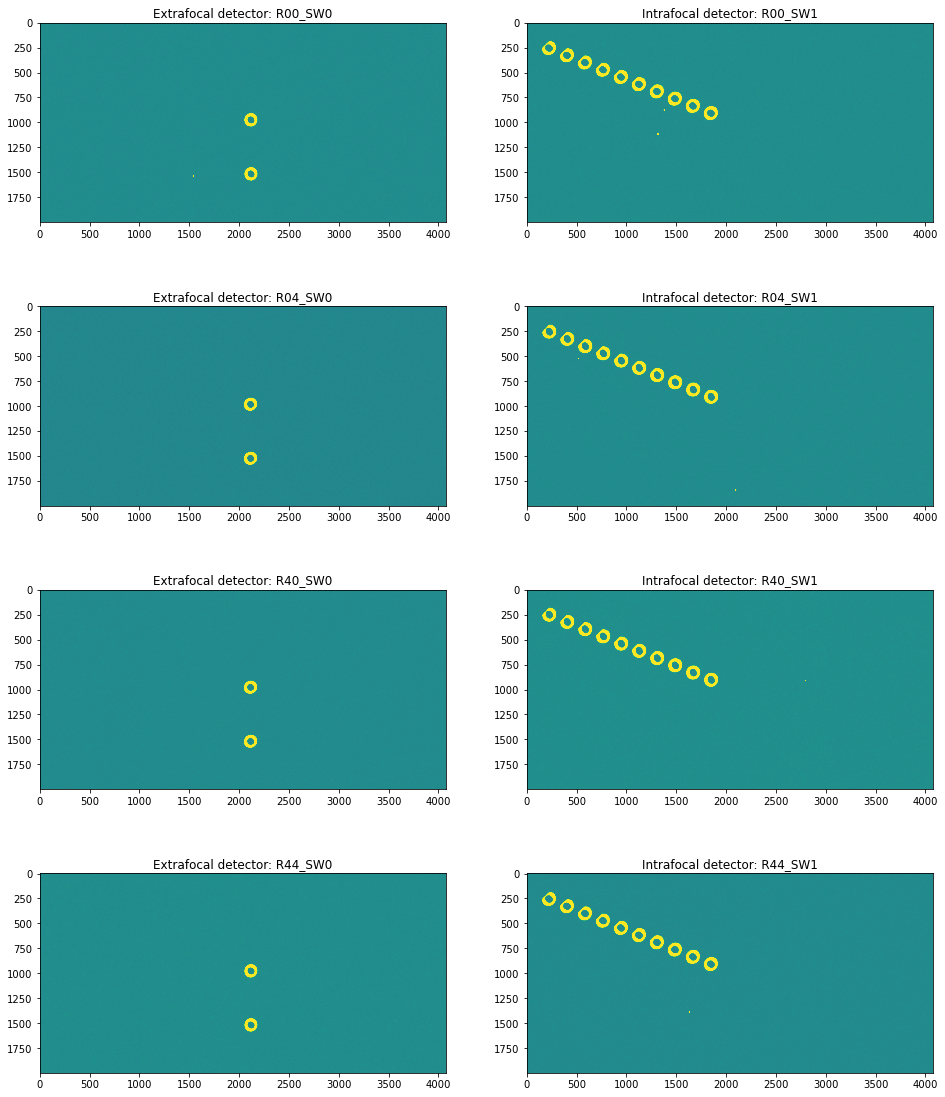

In [4]:
fig = plt.figure(figsize=(16, 20))
i = 1
for extraId in extraDetectorIds:
    fig.add_subplot(4, 2, i)
    extraIm = butler.get('postISRCCD', dataId=extraDataIds[str(extraId)], collections=['ts_phosim_9006000'])
    plt.imshow(extraIm.getImage().getArray(), vmax=50)
    extraDetectorName = extraIm.getDetector().getName()
    plt.title(f'Extrafocal detector: {extraDetectorName}')
    fig.add_subplot(4, 2, i+1)
    intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(extraId+1)], collections=['ts_phosim_9006000'])
    plt.imshow(intraIm.getImage().getArray(), vmax=50)
    intraDetectorName = intraIm.getDetector().getName()
    plt.title(f'Intrafocal detector: {intraDetectorName}')
    i += 2

Let's take a closer look at the donuts by loading the `DonutStamps` for one of the detectors.

In [5]:
dataIdIntra['detector'] = 192
donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdIntra, collections=['ts_phosim_9006000'])

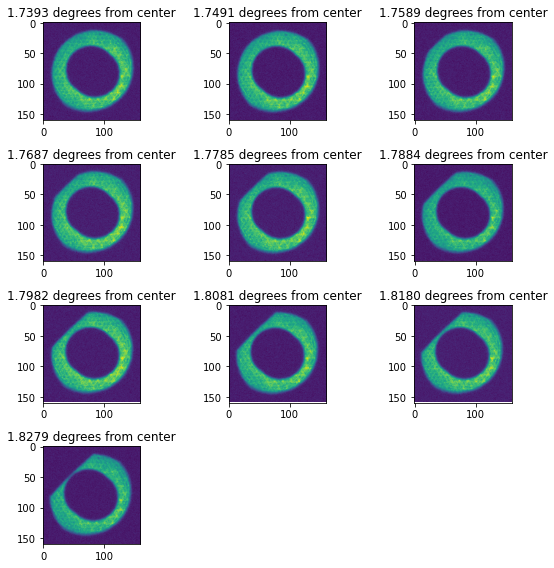

In [6]:
fig = plt.figure(figsize=(8, 8))
distToCenterVals = []
for i in range(10):
    fig.add_subplot(4, 3, i+1)
    dStamp = donutStampsIntra[i]
    plt.imshow(dStamp.stamp_im.getImage().getArray())
    ra = dStamp.sky_position[0].asDegrees()
    dec = dStamp.sky_position[1].asDegrees()
    distToCenter = np.sqrt((360. - ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
plt.tight_layout()

Finally, we show the masks that are used in the closed loop and display that the existing model adds vignetting when calculating the masks.

In [7]:
instDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData')
maskDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData', 'lsst', 'maskMigrate.yaml')
inst = Instrument(instDataPath)
inst.config(CamType.LsstCam, 160)

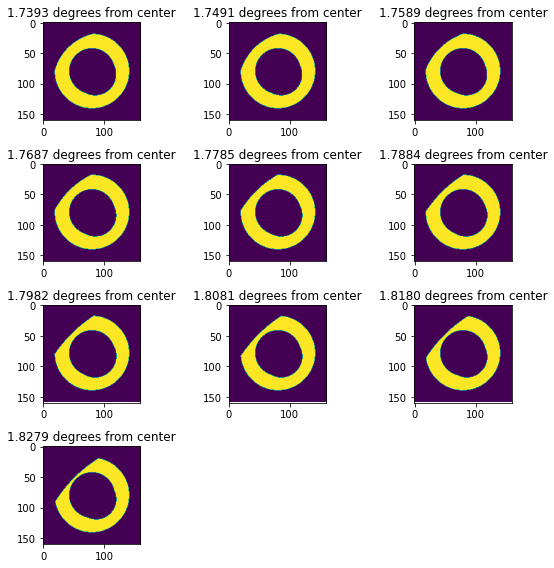

In [8]:
fig = plt.figure(figsize=(8, 8))
distToCenterVals = []
for i in range(10):
    fig.add_subplot(4, 3, i+1)
    dStamp = donutStampsIntra[i]
    dStamp.makeMasks(inst, 'offAxis', 0, 1)
    plt.imshow(dStamp.mask_comp.getArray())
    ra = donutStampsIntra[i].sky_position[0].asDegrees()
    dec = donutStampsIntra[i].sky_position[1].asDegrees()
    distToCenter = np.sqrt((360. - ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
plt.tight_layout()

## Zernike Estimation Performance of Vignetted Donuts

In this section for each wavefront sensor pair we estimate the Zernike coefficients using one of the extra-focal donuts and each of the intra-focal donuts at the various distances from the field center in the images above. We then compare these results with the OPD values to see how well we can reproduce the true values with varying levels of vignetting.

In [9]:
# Load all the individual DonutStamps from the Butler repository
donutStampsExtraDict = {}
donutStampsIntraDict = {}
for extraId in extraDetectorIds:
    dataIdExtra = extraDataIds[str(extraId)]
    dataIdIntra = intraDataIds[str(extraId+1)]
    donutStampsExtra = butler.get('donutStampsExtra', dataId=dataIdExtra, collections=['ts_phosim_9006000'])
    donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdIntra, collections=['ts_phosim_9006000'])
    donutStampsExtraDict[str(extraId)] = donutStampsExtra
    donutStampsIntraDict[str(extraId+1)] = donutStampsIntra

In [10]:
# Initiate the task to estimate the Zernikes
zernConfig = EstimateZernikesCwfsTaskConfig()
zernTask = EstimateZernikesCwfsTask(config=zernConfig)

In [11]:
detectorZerns = {}
for extraId in extraDetectorIds:
    intraId = extraId + 1
    print(f"Calculating Zernikes for detectors {extraId} and {intraId}.")
    zernVals = []
    for i in range(10):
        # Pair up the extra-focal donut with one of the intra-focal donuts and calculate Zernikes
        zernEstimate = zernTask.estimateZernikes(DonutStamps([donutStampsExtraDict[str(extraId)][0]]), 
                                                 DonutStamps([donutStampsIntraDict[str(intraId)][i]]))
        zernVals.append(zernEstimate)
    detectorZerns[str(extraId)] = zernVals

Calculating Zernikes for detectors 191 and 192.
Calculating Zernikes for detectors 195 and 196.
Calculating Zernikes for detectors 199 and 200.
Calculating Zernikes for detectors 203 and 204.


In [12]:
# Load the OPD "Truth" information
opd_truth = np.genfromtxt('/project/aos/vignetting_tests/vignette_test_no_rot/iter0/img/opd.zer')
opd_idx_dict = {'191':2, '195':1, '199':3, '203':0}

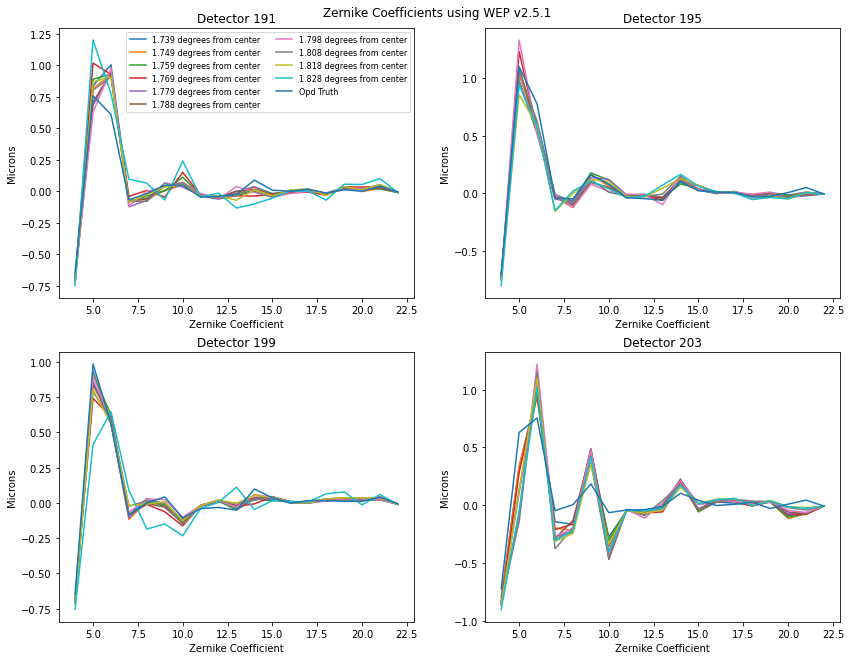

In [13]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(10):
        plt.plot(np.arange(4, 23), detectorZerns[str(extraId)][j][0], label=f'{distToCenterVals[j]:.3f} degrees from center')
    plt.plot(np.arange(4, 23), opd_truth[opd_idx_dict[str(extraId)]], label=f'Opd Truth')
    if i == 1:
        plt.legend(loc=1, ncol=2, fontsize=8)
    plt.title(f'Detector {extraId}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Zernike Coefficients using WEP v2.5.1')
plt.subplots_adjust(top=0.95)

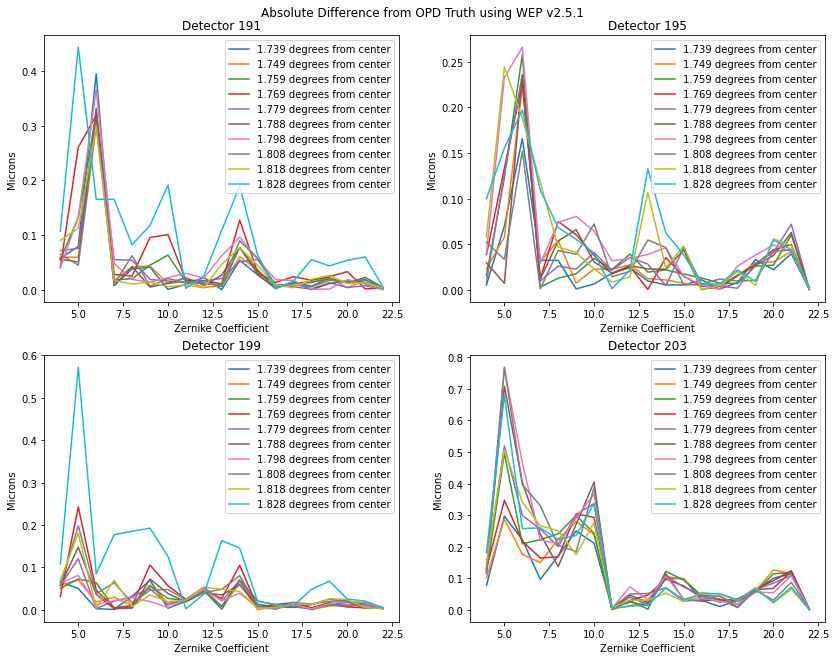

In [14]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(10):
        plt.plot(
            np.arange(4, 23), 
            np.abs(detectorZerns[str(extraId)][j][0]-opd_truth[opd_idx_dict[str(extraId)]]), 
            label=f'{distToCenterVals[j]:.3f} degrees from center')
    plt.legend()
    plt.title(f'Detector {extraId}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Absolute Difference from OPD Truth using WEP v2.5.1')
plt.subplots_adjust(top=0.94)

Across the 4 pairs of wavefront sensors the results are fairly consistent even as vignetting becomes larger. The only case that is consistently worse than non-vignetted donuts is the most extreme vignetting in our test data at 1.828 degrees from the center of the focal plane. This shows that we can mostly ignore vignetting when it occurs in isolated donuts until we get to the most extreme values. 

In the next section we make sure that we can see this in the convergence of the AOS closed loop. Using convergence of the closed loop as the determining factor we will try to define a limit for acceptable donuts based upon their distance from the center of the focal plane.

## Closed loop results with vignetting

Here we created a new dataset of closed loop simulations using `ts_phosim`. In each run we take a single extra-focal donut always at the same location and a single intra-focal donut at a different distance from the center of the field and run the full closed loop simulation. Thus we can test the convergence of the closed loop with varying amounts of vignetting.

### No background, `g_mag` = 15.0

In this first set of tests all the stars are set to `g_mag` = 15.0 and there is no sky background included in the phosim simulations.

In [15]:
field_distances = [1.749, 1.769, 1.788, 1.798, 1.808, 1.813, 1.818, 1.823, 1.828]
field_dist_names = ['175', '177', '179', '180', '181', '1813', '182', '1823', '183']
field_name_dict = {f_name:f_dist for f_name, f_dist in zip(field_dist_names, field_distances)}

In [16]:
PSSN_vals = {}
for field_dist_name in field_dist_names:
    loop_PSSN = []
    for loop_iter in range(10):
        loop_PSSN.append(np.genfromtxt(f'/project/aos/vignetting_tests/closed_loop_tests/no_bg/vignette_test_{field_dist_name}/iter{loop_iter}/img/PSSN.txt'))
    PSSN_vals[field_dist_name] = np.array(loop_PSSN)

Text(0.5, 1.0, 'Closed Loop, 10 iterations, No Background')

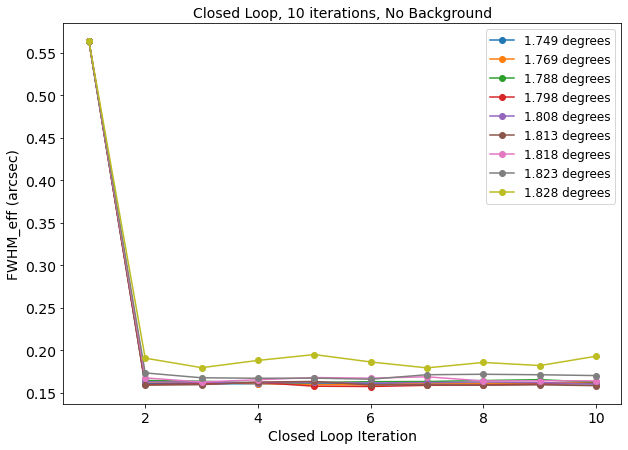

In [17]:
fig = plt.figure(figsize=(10, 7))
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        PSSN_vals[field_dist_name][:, 1, 4], 
        '-o', 
        label=f"{field_name_dict[field_dist_name]} degrees"
    )
plt.legend(fontsize=12)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, No Background', size=14)

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, No Background')

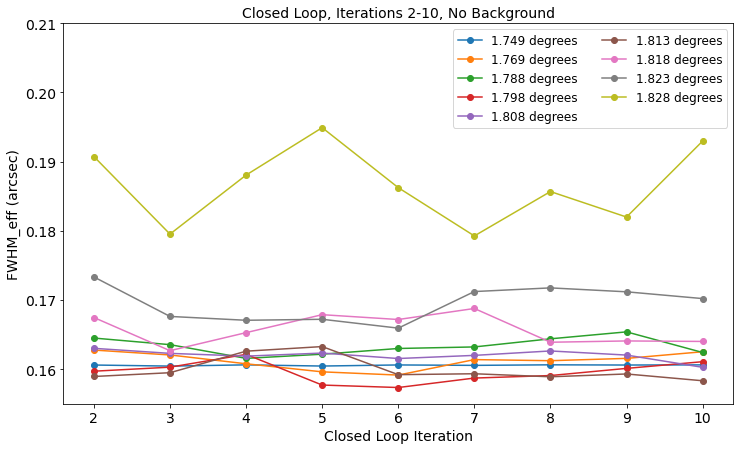

In [18]:
fig = plt.figure(figsize=(12, 7))
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(2,11),
        PSSN_vals[field_dist_name][1:, 1, 4], 
        '-o', 
        label=f"{field_name_dict[field_dist_name]} degrees"
    )
plt.legend(fontsize=12, ncol=2)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.155, 0.21))
plt.title('Closed Loop, Iterations 2-10, No Background', size=14)

As we can see in the top plot, all of the closed loop runs converge but there is a significant deterioration in the results at the highest level of vignetting. 

In the second plot we zoom into iterations 2-10 and see that there are a group of very similar results up to and including donuts at 1.813 degrees from the center of the focal plane. After this point there seems to be a slight deterioration of the FWHM convergence of about 0.01 arcseconds at 1.818 and 1.823 degrees. Finally, the highest amount of vigentting in our simulations at 1.828 degrees from the center of the focal plane also converges but at around 0.19 arcsec which is ~0.03 arcsec worse than the non-vignetted value.

In the next section, we look to reproduce these results with sky background added into the simulation.

### Quick Background, stars with magnitude g=15.9 (faint limit of AOS)

In this test, we add background and also simulate stars at the faint limit of the AOS system ([in g-band this is 15.90](https://github.com/lsst-ts/ts_wep/blob/develop/policy/task/magLimitStar.yaml)). We want to make sure that the AOS system can deal with vignetting at this faint limit as well as it can in other situations.

In [19]:
faint_quickbg_PSSN_vals = {}
for field_dist_name in field_dist_names:
    loop_PSSN = []
    for loop_iter in range(10):
        loop_PSSN.append(np.genfromtxt(f'/project/aos/vignetting_tests/closed_loop_tests/quickbg_mag15p9/vignette_test_{field_dist_name}/iter{loop_iter}/img/PSSN.txt'))
    faint_quickbg_PSSN_vals[field_dist_name] = np.array(loop_PSSN)

Text(0.5, 1.0, 'Closed Loop, 10 iterations, Quick Background, stars g_mag=15.9')

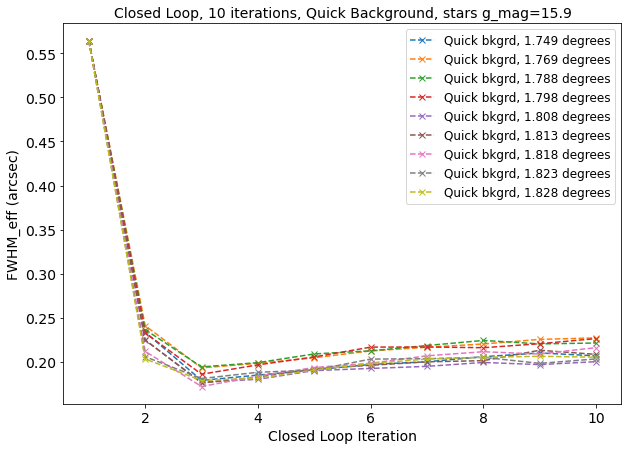

In [20]:
fig = plt.figure(figsize=(10, 7))
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1,11),
        faint_quickbg_PSSN_vals[field_dist_name][:, 1, 4], 
        '--x', 
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
plt.legend(fontsize=12)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, Quick Background, stars g_mag=15.9', size=14)

Here we see that the AOS system can handle the vignetting even at the faint limit and the closed loop converges for all the same situations as it did in the no background simulation.

Text(0.5, 1.0, 'Closed Loop, 10 iterations, No Background vs Quick Background (g_mag=15.9)')

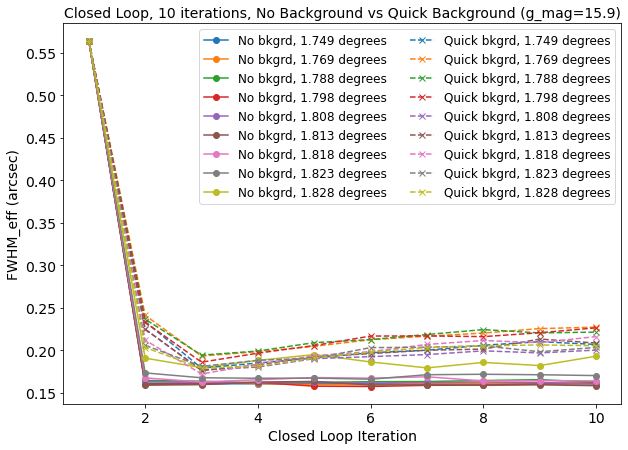

In [21]:
fig = plt.figure(figsize=(10, 7))
i = 0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        PSSN_vals[field_dist_name][:, 1, 4], 
        '-o', 
        c=f"C{i}",
        label=f"No bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
i=0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        faint_quickbg_PSSN_vals[field_dist_name][:, 1, 4], 
        '--x',
        c=f"C{i}",
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
plt.legend(fontsize=12, ncol=2)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, No Background vs Quick Background (g_mag=15.9)', size=14)

Comparing the results with background to the no background results we see that the background with faint stars does lead to convergence of the closed loop at a higher FWHM seeing value.

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, No Background vs Quick Background (g_mag=15.9)')

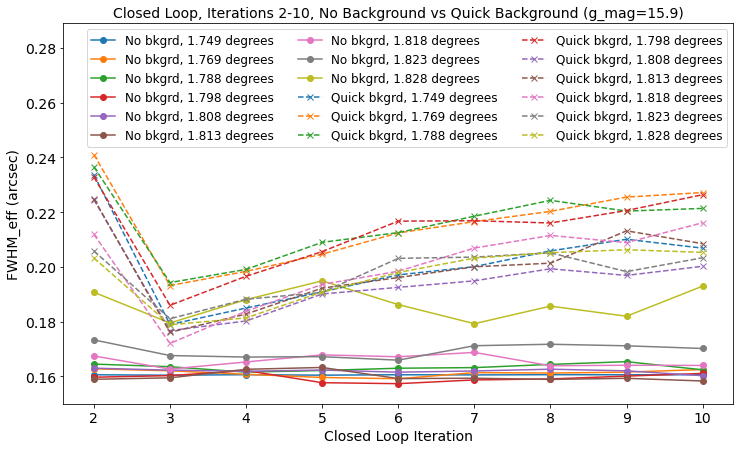

In [22]:
fig = plt.figure(figsize=(12, 7))
i = 0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist_name][1:, 1, 4], 
        '-o', 
        c=f"C{i}",
        label=f"No bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
i=0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(2, 11),
        faint_quickbg_PSSN_vals[field_dist_name][1:, 1, 4], 
        '--x',
        c=f"C{i}",
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
plt.legend(fontsize=12, ncol=3)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.15, 0.289))
plt.title('Closed Loop, Iterations 2-10, No Background vs Quick Background (g_mag=15.9)', size=14)

Zooming into iterations 2-10 it looks like the faint stars with background have about 0.04 arcseconds worse seeing after convergence.

In the final section, we will run the same test with brighter stars to see if brighter stars lead to better results when we run with sky background included.

### Quick Background, stars with magnitude g=13.0

Here we run the same tests as above but the stars are set to g-band magnitude of 13.0.

In [23]:
bright_quickbg_PSSN_vals = {}
for field_dist_name in field_dist_names:
    loop_PSSN = []
    for loop_iter in range(10):
        loop_PSSN.append(np.genfromtxt(f'/project/aos/vignetting_tests/closed_loop_tests/quickbg_mag12/vignette_test_{field_dist_name}/iter{loop_iter}/img/PSSN.txt'))
    bright_quickbg_PSSN_vals[field_dist_name] = np.array(loop_PSSN)

Text(0.5, 1.0, 'Closed Loop, 10 iterations, Quick Background, stars g_mag=13.0')

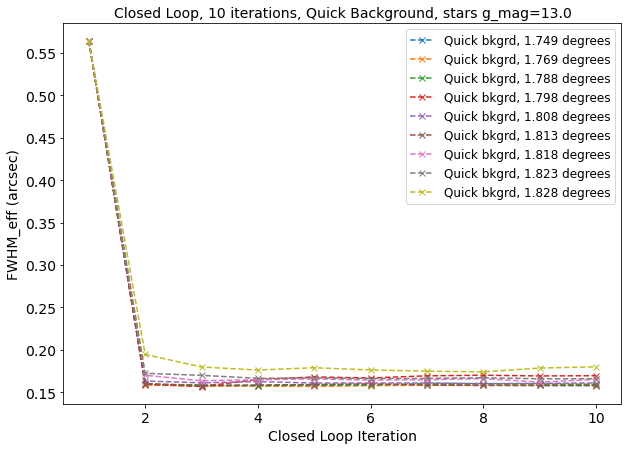

In [24]:
fig = plt.figure(figsize=(10, 7))
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        bright_quickbg_PSSN_vals[field_dist_name][:, 1, 4], 
        '--x', 
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
plt.legend(fontsize=12)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, Quick Background, stars g_mag=13.0', size=14)

Text(0.5, 1.0, 'Closed Loop, 10 iterations, No Background vs Quick Background (g_mag=13.0)')

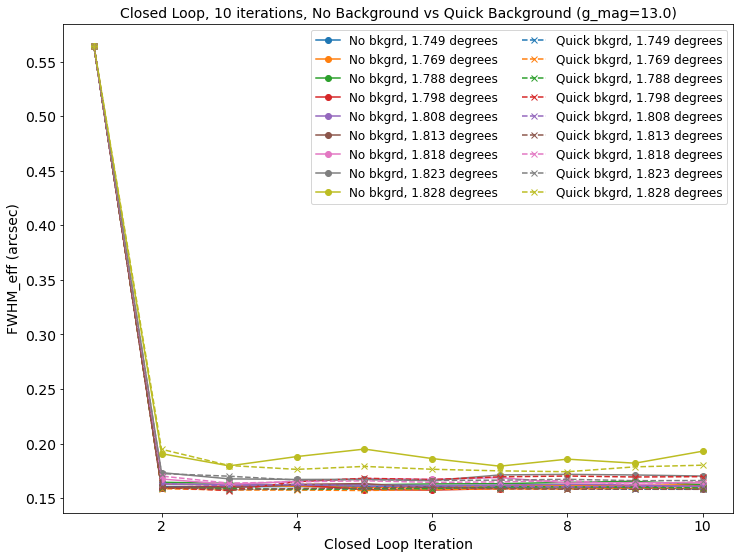

In [25]:
fig = plt.figure(figsize=(12, 9))
i = 0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        PSSN_vals[field_dist_name][:, 1, 4], 
        '-o', 
        c=f"C{i}",
        label=f"No bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
i=0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(1, 11),
        bright_quickbg_PSSN_vals[field_dist_name][:, 1, 4], 
        '--x',
        c=f"C{i}",
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
plt.legend(fontsize=12, ncol=2)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, No Background vs Quick Background (g_mag=13.0)', size=14)

Here it looks like the g=13.0 w/ background results lie right on top of the original, no background results. This indicates that with brighter stars we can neutralize most of the effect of the background on the AOS results.

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, No Background vs Quick Background (g_mag=13.0)')

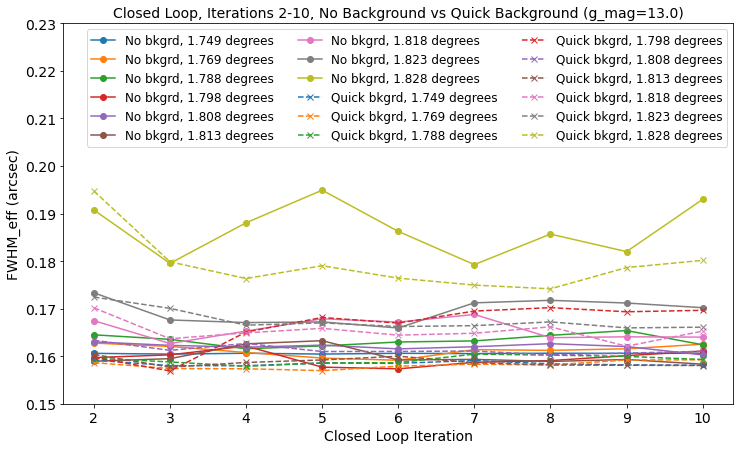

In [26]:
fig = plt.figure(figsize=(12, 7))
i = 0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist_name][1:, 1, 4], 
        '-o', 
        c=f"C{i}",
        label=f"No bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
i=0
for field_dist_name in field_dist_names:
    plt.plot(
        np.arange(2, 11),
        bright_quickbg_PSSN_vals[field_dist_name][1:, 1, 4], 
        '--x',
        c=f"C{i}",
        label=f"Quick bkgrd, {field_name_dict[field_dist_name]} degrees"
    )
    i+=1
plt.legend(fontsize=12, ncol=3)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.15, 0.23))
plt.title('Closed Loop, Iterations 2-10, No Background vs Quick Background (g_mag=13.0)', size=14)

Here zooming into the results of iterations 2-10 it looks like once again the 1.813 degree limit will be effective with sky background present.

In the final section below, we calculate how much a limit on our donut sources of 1.813 degrees from the field center will affect our usable area on the intra-focal detectors.

## Calculate area of detector cut off

Here we will calculate the distance each pixel in the intra-focal detector is from the center of the field and then calculate how many pixels are beyond the limit we will set for the AOS baseline pipeline at 1.813 degrees.

In [27]:
intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(192)], collections=['ts_phosim_9006000'])

In [28]:
# Create meshgrid for contours and calculate distance to center for points in grid
import lsst.geom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE

X, Y = np.meshgrid(np.arange(0, 4096, 5), np.arange(0, 2001, 5))
Z = np.zeros(np.shape(X))

for x_idx in np.arange(0, 4096, 5):
    for y_idx in np.arange(0, 2001, 5):
        # Use detector object to convert between Pixels and Field Angle
        field_xy = intraIm.getDetector().transform(
            lsst.geom.Point2D(x_idx, y_idx), PIXELS, FIELD_ANGLE
        )
        field_dist = np.sqrt(field_xy[0]**2 + field_xy[1]**2)
        Z[int(y_idx/5), int(x_idx/5)] = np.degrees(field_dist)


Text(0, 0.5, 'Y Pixels')

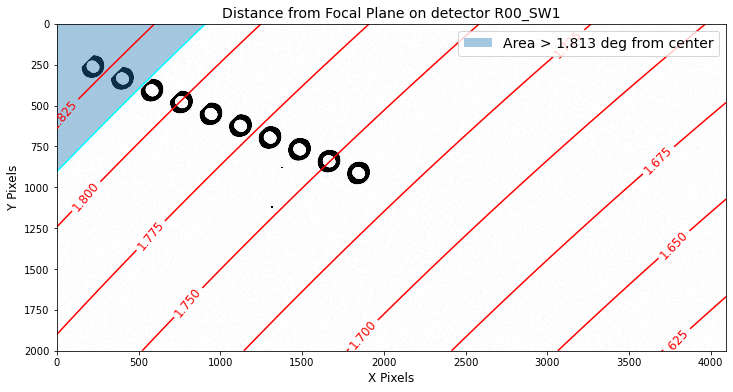

In [29]:
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
plt.imshow(intraIm.getImage().getArray(), vmax=50, vmin=0, cmap=plt.get_cmap('Greys'))
C = plt.contour(X, Y, Z, colors='red', levels=np.arange(1.60, 1.91, 0.025))
C1 = plt.contour(X, Y, Z, colors='cyan', levels=[1.813])
ax.clabel(C, inline=True, fontsize=12)
ax.fill_between(C1.allsegs[0][0][:,0], C1.allsegs[0][0][:,1], np.zeros(len(C1.allsegs[0][0])), alpha=0.4, label='Area > 1.813 deg from center')
plt.title(f'Distance from Focal Plane on detector {intraIm.getDetector().getName()}', size=14)
plt.legend(fontsize=14)
plt.xlabel('X Pixels', size=12)
plt.ylabel('Y Pixels', size=12)


In [30]:
frac_cutoff = len(np.where(Z > 1.813)[0])/(np.shape(Z)[0]*np.shape(Z)[1])

In [31]:
print(f"The amount of the detector cutoff is {frac_cutoff*100:.4f} percent for detector {intraIm.getDetector().getName()}.")

The amount of the detector cutoff is 4.9906 percent for detector R00_SW1.


Setting the limit of sources used in our baseline AOS pipeline still leaves us 95% of the detector area. This seems acceptable and it does not look like we need to look at further vignetting algorithms but should focus our efforts on deblending to make sure we make the best use of the remaining 95% of the detector to get sources.